# ⚡ PERFORMANCE OPTIMIZATIONS

This notebook has been optimized for faster execution:
- Reduced rolling windows from 5 to 3 per column
- Only compute rolling features for request_count (not bytes_total)
- Skip min/max for large windows
- Efficient missing value handling

**Estimated runtime: 2-3 minutes** (down from 10+ minutes)

# 03 - Feature Engineering

This notebook handles:
1. Time-based features (hour, day_of_week, is_weekend, etc.)
2. Lag features (previous periods)
3. Rolling statistics (moving averages, std)
4. Advanced features (spike detection, trends)
5. Final feature set preparation

In [ ]:
# Standard imports
import sys
from pathlib import Path

# Add project root to path
project_root = Path.cwd().parent
sys.path.insert(0, str(project_root))

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Project imports
from src.features.time_features import TimeFeatureExtractor
from src.features.lag_features import LagFeatureExtractor
from src.features.rolling_features import RollingFeatureExtractor
from src.features.advanced_features import AdvancedFeatureExtractor

pd.set_option('display.max_columns', 50)
plt.style.use('seaborn-v0_8-whitegrid')

print(f"Project root: {project_root}")

Project root: C:\Users\Admin\OneDrive\Documents\python\datafollow


## 1. Load Aggregated Data

In [ ]:
# Paths
DATA_DIR = project_root / "DATA"
PROCESSED_DIR = DATA_DIR / "processed"

# Load 5-minute aggregated data (primary focus)
df_train = pd.read_parquet(PROCESSED_DIR / "train_5m.parquet")
df_test = pd.read_parquet(PROCESSED_DIR / "test_5m.parquet")

print(f"Train shape: {df_train.shape}")
print(f"Test shape: {df_test.shape}")
print(f"\nColumns: {list(df_train.columns)}")

Train shape: (15264, 11)


Test shape: (2592, 11)

Columns: ['timestamp', 'request_count', 'unique_hosts', 'error_count', 'error_rate', 'success_rate', 'bytes_total', 'bytes_avg', 'bytes_max', 'requests_per_host', 'bytes_per_request']


## 2. Time Features

In [ ]:
# Initialize time feature extractor
print("Extracting time features...")
time_extractor = TimeFeatureExtractor(cyclical=True)

# Extract time features
df_train = time_extractor.transform(df_train)
df_test = time_extractor.transform(df_test)

print(f"✓ After time features: {df_train.shape}")
print(f"  New features: {time_extractor.get_feature_names()}")

Extracting time features...
✓ After time features: (15264, 34)
  New features: ['year', 'month', 'day', 'hour', 'minute', 'day_of_week', 'day_of_year', 'week_of_year', 'is_weekend', 'is_business_hour', 'is_peak_hour', 'time_of_day', 'part_of_day', 'hour_sin', 'hour_cos', 'dow_sin', 'dow_cos', 'dom_sin', 'dom_cos', 'month_sin', 'month_cos', 'mod_sin', 'mod_cos']


In [ ]:
# View time features
time_cols = ['timestamp', 'hour', 'day_of_week', 'is_weekend', 'is_business_hour', 'is_peak_hour', 'hour_sin', 'hour_cos']
df_train[time_cols].head(10)

,timestamp,hour,day_of_week,is_weekend,is_business_hour,is_peak_hour,hour_sin,hour_cos
0,1995-07-01 00:00:00,0,5,1,0,0,0.0,1.0
1,1995-07-01 00:05:00,0,5,1,0,0,0.0,1.0
2,1995-07-01 00:10:00,0,5,1,0,0,0.0,1.0
3,1995-07-01 00:15:00,0,5,1,0,0,0.0,1.0
4,1995-07-01 00:20:00,0,5,1,0,0,0.0,1.0
5,1995-07-01 00:25:00,0,5,1,0,0,0.0,1.0
6,1995-07-01 00:30:00,0,5,1,0,0,0.0,1.0
7,1995-07-01 00:35:00,0,5,1,0,0,0.0,1.0
8,1995-07-01 00:40:00,0,5,1,0,0,0.0,1.0
9,1995-07-01 00:45:00,0,5,1,0,0,0.0,1.0


## 3. Lag Features

In [ ]:
# Initialize lag extractor for 5-minute data
lag_extractor = LagFeatureExtractor(window='5min')

print(f"Using lags: {lag_extractor.lags}")
print("(1=5min, 3=15min, 6=30min, 12=1hr, 60=5hr, 288=1day)")

Using lags: [1, 3, 6, 12, 60, 288]
(1=5min, 3=15min, 6=30min, 12=1hr, 60=5hr, 288=1day)


In [ ]:
# Extract lag features with differences
print("Extracting lag features for request_count...")
df_train = lag_extractor.transform_with_diff(df_train, target_cols=['request_count'])
df_test = lag_extractor.transform_with_diff(df_test, target_cols=['request_count'])

# Also add lags for bytes (without diff to save time)
print("Extracting lag features for bytes_total...")
df_train = lag_extractor.transform(df_train, target_cols=['bytes_total'])
df_test = lag_extractor.transform(df_test, target_cols=['bytes_total'])

print(f"✓ After lag features: {df_train.shape}")

Extracting lag features for request_count...


Extracting lag features for bytes_total...
✓ After lag features: (15264, 58)


In [ ]:
# View lag features
lag_cols = [c for c in df_train.columns if 'lag_' in c][:8]
df_train[['timestamp', 'request_count'] + lag_cols].head(15)

,timestamp,request_count,request_count_lag_1,request_count_lag_3,request_count_lag_6,request_count_lag_12,request_count_lag_60,request_count_lag_288,bytes_total_lag_1,bytes_total_lag_3
0,1995-07-01 00:00:00,301,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1995-07-01 00:05:00,267,301.0,NaN,NaN,NaN,NaN,NaN,5277675.0,NaN
2,1995-07-01 00:10:00,242,267.0,NaN,NaN,NaN,NaN,NaN,5041043.0,NaN
3,1995-07-01 00:15:00,282,242.0,301.0,NaN,NaN,NaN,NaN,6111846.0,5277675.0
4,1995-07-01 00:20:00,318,282.0,267.0,NaN,NaN,NaN,NaN,4559748.0,5041043.0
5,1995-07-01 00:25:00,344,318.0,242.0,NaN,NaN,NaN,NaN,6315960.0,6111846.0
6,1995-07-01 00:30:00,326,344.0,282.0,301.0,NaN,NaN,NaN,6223927.0,4559748.0
7,1995-07-01 00:35:00,361,326.0,318.0,267.0,NaN,NaN,NaN,9250029.0,6315960.0
8,1995-07-01 00:40:00,319,361.0,344.0,242.0,NaN,NaN,NaN,7024223.0,6223927.0
9,1995-07-01 00:45:00,205,319.0,326.0,282.0,NaN,NaN,NaN,6146572.0,9250029.0


## 4. Rolling Features

In [ ]:
# Initialize rolling extractor
rolling_extractor = RollingFeatureExtractor(time_window='5min')

print(f"Using windows: {rolling_extractor.windows}")
print("(3=15min, 6=30min, 12=1hr, 24=2hr, 60=5hr)")

Using windows: [3, 12, 60]
(3=15min, 6=30min, 12=1hr, 24=2hr, 60=5hr)


In [ ]:
# Extract rolling features (optimized - only key features)
print("Computing rolling features...")
df_train = rolling_extractor.transform(df_train, target_cols=['request_count'])
df_test = rolling_extractor.transform(df_test, target_cols=['request_count'])

# Add EWM features for request_count only
print("Computing EWM features...")
df_train = rolling_extractor.transform_ewm(df_train, target_cols=['request_count'])
df_test = rolling_extractor.transform_ewm(df_test, target_cols=['request_count'])

print(f"After rolling features: {df_train.shape}")

Computing rolling features...
Computing EWM features...


After rolling features: (15264, 74)


In [ ]:
# View rolling features
rolling_cols = [c for c in df_train.columns if 'rolling_' in c or 'ewm_' in c][:8]
df_train[['timestamp', 'request_count'] + rolling_cols].head(15)

,timestamp,request_count,request_count_rolling_mean_3,request_count_rolling_std_3,request_count_rolling_min_3,request_count_rolling_max_3,request_count_rolling_mean_12,request_count_rolling_std_12,request_count_rolling_min_12,request_count_rolling_max_12
0,1995-07-01 00:00:00,301,301.000000,NaN,301.0,301.0,301.000000,NaN,301.0,301.0
1,1995-07-01 00:05:00,267,284.000000,24.041631,267.0,301.0,284.000000,24.041631,267.0,301.0
2,1995-07-01 00:10:00,242,270.000000,29.614186,242.0,301.0,270.000000,29.614186,242.0,301.0
3,1995-07-01 00:15:00,282,263.666667,20.207259,242.0,282.0,273.000000,24.913183,242.0,301.0
4,1995-07-01 00:20:00,318,280.666667,38.017540,242.0,318.0,282.000000,29.504237,242.0,318.0
5,1995-07-01 00:25:00,344,314.666667,31.134118,282.0,344.0,292.333333,36.565922,242.0,344.0
6,1995-07-01 00:30:00,326,329.333333,13.316656,318.0,344.0,297.142857,35.723142,242.0,344.0
7,1995-07-01 00:35:00,361,343.666667,17.502381,326.0,361.0,305.125000,40.044395,242.0,361.0
8,1995-07-01 00:40:00,319,335.333333,22.501852,319.0,361.0,306.666667,37.742549,242.0,361.0
9,1995-07-01 00:45:00,205,295.000000,80.721744,205.0,361.0,296.500000,47.956578,205.0,361.0


# Initialize advanced extractor
print("Extracting advanced features (spike detection, trends, special events)...")
advanced_extractor = AdvancedFeatureExtractor(spike_threshold=3.0, window=15)

# Extract advanced features (includes event features)
df_train = advanced_extractor.transform(df_train)
df_test = advanced_extractor.transform(df_test)

print(f"✓ After advanced features: {df_train.shape}")

# Show special events detected
if 'is_special_event' in df_train.columns:
    events_found = df_train[df_train['is_special_event'] == 1]['event_name'].unique()
    print(f"\n✓ Special events detected: {len(events_found)}")
    for event in events_found[:5]:
        print(f"  - {event}")

In [ ]:
# Initialize advanced extractor
print("Extracting advanced features (spike detection, trends)...")
advanced_extractor = AdvancedFeatureExtractor(spike_threshold=3.0, window=15)

# Extract advanced features
df_train = advanced_extractor.transform(df_train)
df_test = advanced_extractor.transform(df_test)

print(f"✓ After advanced features: {df_train.shape}")

Extracting advanced features (spike detection, trends)...


✓ After advanced features: (15264, 91)


In [ ]:
# View spike detection
spike_data = df_train[df_train['is_spike'] == 1][['timestamp', 'request_count', 'spike_score', 'spike_magnitude']]
print(f"Detected spikes: {len(spike_data)}")
spike_data.head(10)

Detected spikes: 10


,timestamp,request_count,spike_score,spike_magnitude
1818,1995-07-07 07:30:00,238,3.031809,0.031809
4697,1995-07-17 07:25:00,207,3.162328,0.162328
8928,1995-08-01 00:00:00,220,3.614784,0.614784
9559,1995-08-03 04:35:00,10,3.614784,0.614784
9610,1995-08-03 08:50:00,53,3.184271,0.184271
9630,1995-08-03 10:30:00,18,3.120197,0.120197
9641,1995-08-03 11:25:00,135,3.531434,0.531434
9642,1995-08-03 11:30:00,386,3.405585,0.405585
10767,1995-08-07 09:15:00,358,3.006903,0.006903
14515,1995-08-20 09:35:00,169,3.098340,0.098340


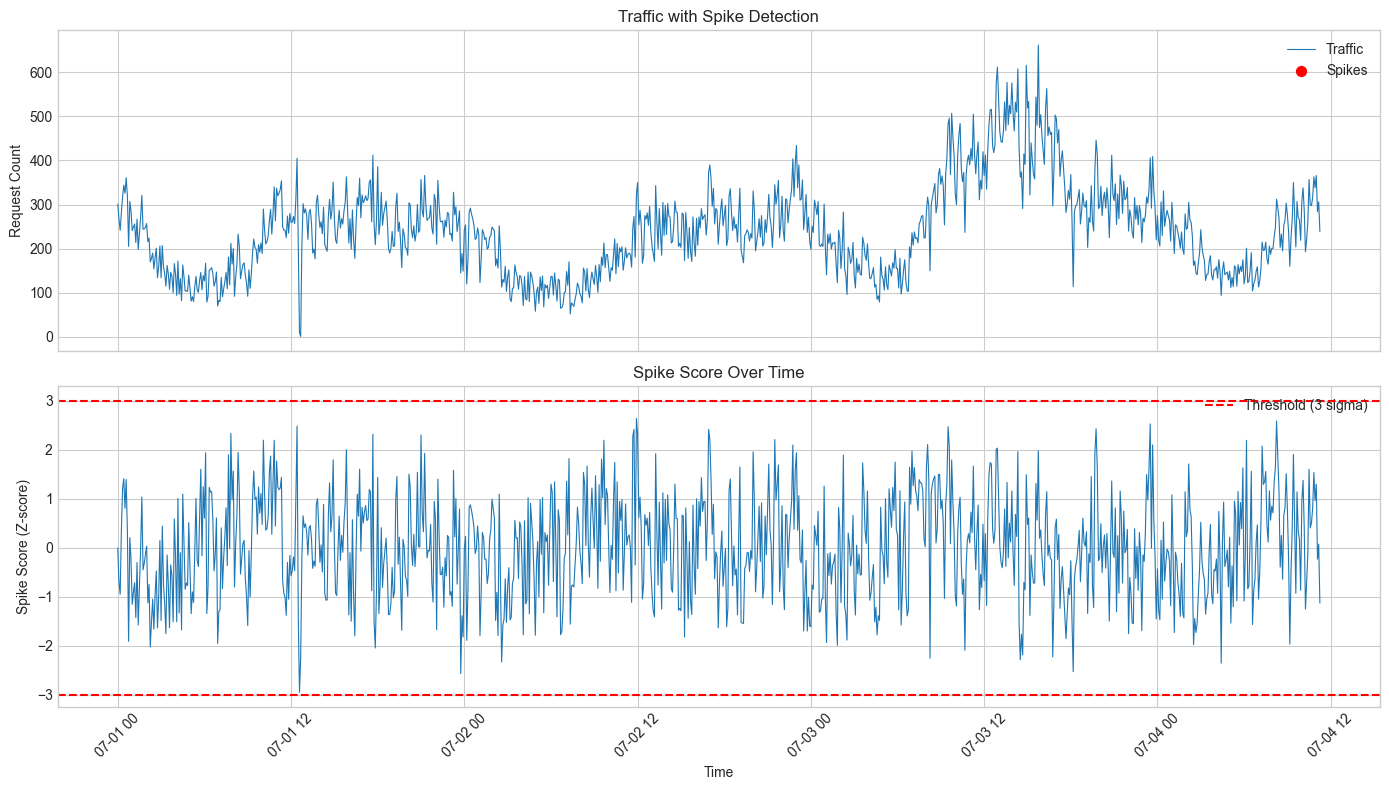

In [ ]:
# Visualize spike detection (using smaller sample for speed)
SHOW_PLOT = True  # Set to False to skip visualization

if SHOW_PLOT:
    fig, axes = plt.subplots(2, 1, figsize=(14, 8), sharex=True)

    # Sample first week (limit to 1000 points for faster plotting)
    sample = df_train.head(1000)

    # Traffic with spikes marked
    ax1 = axes[0]
    ax1.plot(sample['timestamp'], sample['request_count'], linewidth=0.8, label='Traffic')
    spikes = sample[sample['is_spike'] == 1]
    ax1.scatter(spikes['timestamp'], spikes['request_count'], color='red', s=50, label='Spikes', zorder=5)
    ax1.set_ylabel('Request Count')
    ax1.set_title('Traffic with Spike Detection')
    ax1.legend()

    # Spike score
    ax2 = axes[1]
    ax2.plot(sample['timestamp'], sample['spike_score'], linewidth=0.8)
    ax2.axhline(y=3, color='r', linestyle='--', label='Threshold (3 sigma)')
    ax2.axhline(y=-3, color='r', linestyle='--')
    ax2.set_ylabel('Spike Score (Z-score)')
    ax2.set_xlabel('Time')
    ax2.set_title('Spike Score Over Time')
    ax2.legend()

    axes[-1].tick_params(axis='x', rotation=45)
    plt.tight_layout()
    plt.show()
else:
    print("Visualization skipped (set SHOW_PLOT=True to enable)")

## 6. Handle Missing Values

In [ ]:
# Check for NaN values
nan_counts = df_train.isna().sum()
nan_cols = nan_counts[nan_counts > 0].sort_values(ascending=False)

print(f"Columns with NaN values: {len(nan_cols)}")
print("\nTop 10 columns with NaN:")
print(nan_cols.head(10))

Columns with NaN values: 41

Top 10 columns with NaN:
request_count_pct_change_1        1463
request_count_pct_change_3        1458
request_count_pct_change_6        1448
request_count_pct_change_12       1445
request_count_pct_change_60       1410
request_count_vs_yesterday_pct    1293
request_count_pct_change_288      1293
request_count_diff_288             288
bytes_total_lag_288                288
request_count_vs_yesterday         288
dtype: int64


In [ ]:
# NaN values are from lag/rolling features at the beginning
# Strategy: Forward fill (ffill) for lag/rolling features

print("Filling missing values...")

# Get numeric columns only
numeric_cols = df_train.select_dtypes(include=[np.number]).columns

# Forward fill - use the modern .ffill() method instead of deprecated fillna(method='ffill')
df_train[numeric_cols] = df_train[numeric_cols].ffill().fillna(0)
df_test[numeric_cols] = df_test[numeric_cols].ffill().fillna(0)

# Verify no NaN remaining
print(f"NaN after fill - Train: {df_train[numeric_cols].isna().sum().sum()}")
print(f"NaN after fill - Test: {df_test[numeric_cols].isna().sum().sum()}")

## 7. Feature Correlation Analysis

In [ ]:
# Compute correlation with target
target = 'request_count'
numeric_features = df_train.select_dtypes(include=[np.number]).columns.tolist()
numeric_features = [f for f in numeric_features if f != target]

correlations = df_train[numeric_features + [target]].corr()[target].drop(target).sort_values(ascending=False)

print("Top 20 features by correlation with request_count:")
print(correlations.head(20))

Top 20 features by correlation with request_count:
request_count_pct_of_max         1.000000
request_count_ewm_mean_5         0.972426
request_count_rolling_mean_3     0.968533
unique_hosts                     0.965023
request_count_rolling_max_3      0.959317
request_count_rolling_min_3      0.953572
request_count_ewm_mean_15        0.942103
request_count_rolling_mean_12    0.935759
request_count_rolling_max_12     0.924422
request_count_lag_1              0.922627
request_count_bb_upper           0.913162
request_count_ewm_mean_30        0.908940
request_count_lag_3              0.888990
request_count_rolling_min_12     0.880484
bytes_total                      0.878913
request_count_lag_6              0.870938
request_count_bb_lower           0.869451
request_count_lag_12             0.836387
bytes_total_lag_1                0.824512
bytes_total_lag_3                0.798420
Name: request_count, dtype: float64


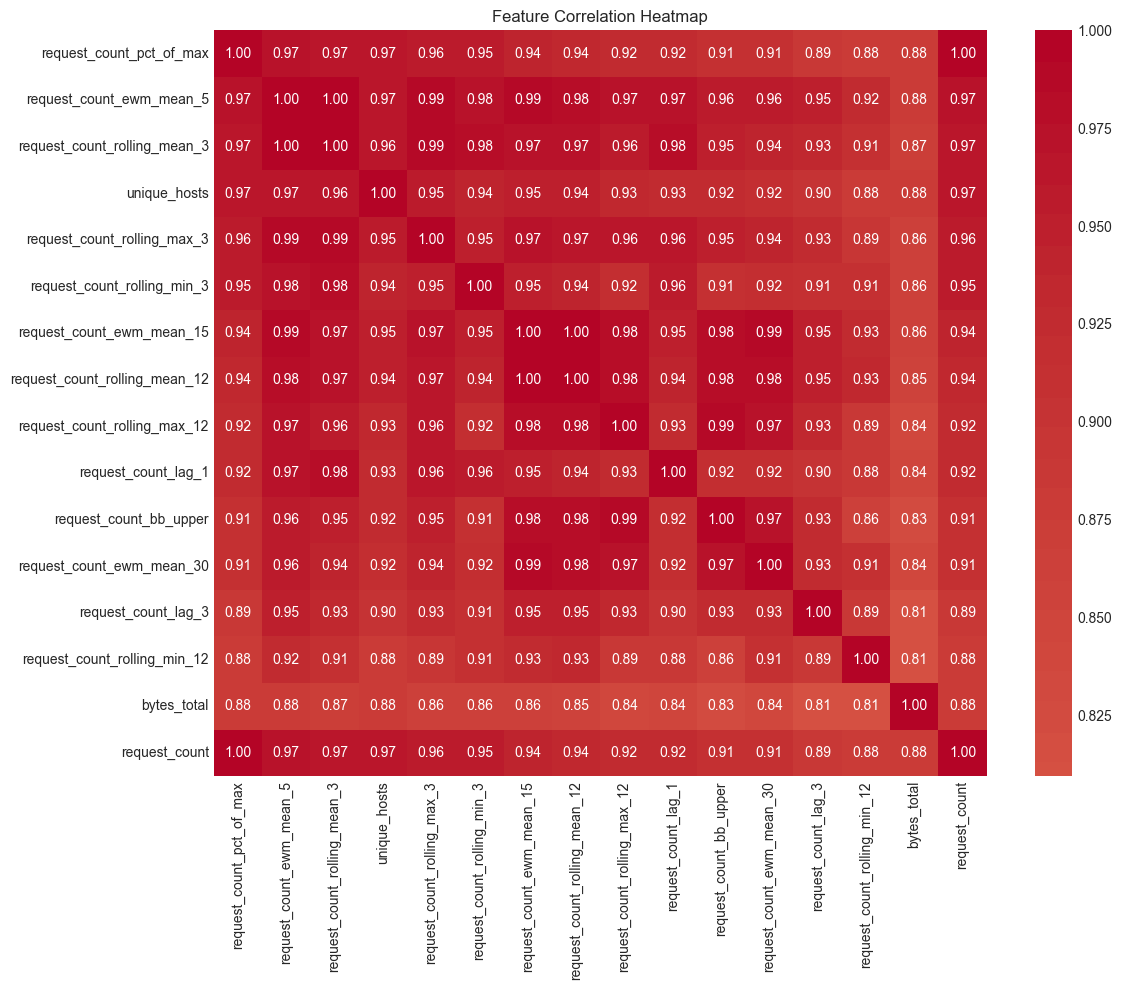

In [ ]:
# Correlation heatmap for top features
SHOW_HEATMAP = True  # Set to False to skip

if SHOW_HEATMAP:
    top_features = correlations.head(15).index.tolist() + [target]

    fig, ax = plt.subplots(figsize=(12, 10))
    corr_matrix = df_train[top_features].corr()
    sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0, ax=ax)
    ax.set_title('Feature Correlation Heatmap')
    plt.tight_layout()
    plt.show()
else:
    print("Heatmap skipped (set SHOW_HEATMAP=True to enable)")

## 8. Final Feature Summary

## 8. ML-Based Anomaly Detection (NEW!)

In [ ]:
# Import anomaly detector
from src.features.anomaly_detector import TrafficAnomalyDetector, SKLEARN_AVAILABLE

if not SKLEARN_AVAILABLE:
    print("⚠️ scikit-learn not installed. Installing...")
    import subprocess
    subprocess.check_call([sys.executable, '-m', 'pip', 'install', 'scikit-learn'])
    from src.features.anomaly_detector import TrafficAnomalyDetector

print("✓ IsolationForest anomaly detector loaded")

In [ ]:
# Select features for anomaly detection
anomaly_features = [
    'request_count',
    'unique_hosts',
    'error_rate',
    'bytes_per_request',
    'request_count_rolling_mean_12',
    'request_count_rolling_std_12',
]

# Filter to existing features
anomaly_features = [f for f in anomaly_features if f in df_train.columns]
print(f"Using {len(anomaly_features)} features for anomaly detection:")
print(f"  {anomaly_features}")

In [ ]:
# Train IsolationForest on training data
print("Training IsolationForest (contamination=1%)...")
detector = TrafficAnomalyDetector(contamination=0.01, random_state=42)

# Fit on train, predict on both train and test
X_train = df_train[anomaly_features].fillna(0)
X_test = df_test[anomaly_features].fillna(0)

predictions_train = detector.fit_predict(X_train)
predictions_test = detector.predict(X_test)

# Get anomaly scores
scores_train = detector.decision_function(X_train)
scores_test = detector.decision_function(X_test)

# Add to DataFrames (-1 = anomaly, 1 = normal)
df_train['is_anomaly_ml'] = (predictions_train == -1).astype(int)
df_test['is_anomaly_ml'] = (predictions_test == -1).astype(int)

df_train['anomaly_score_ml'] = scores_train
df_test['anomaly_score_ml'] = scores_test

# Calculate agreement with Z-score method
if 'is_spike' in df_train.columns:
    df_train['anomaly_agreement'] = ((df_train['is_spike'] == 1) & (df_train['is_anomaly_ml'] == 1)).astype(int)
    df_test['anomaly_agreement'] = ((df_test['is_spike'] == 1) & (df_test['is_anomaly_ml'] == 1)).astype(int)

print(f"\n✓ Anomaly Detection Results:")
print(f"  Train: {df_train['is_anomaly_ml'].sum()} anomalies ({df_train['is_anomaly_ml'].mean()*100:.2f}%)")
print(f"  Test: {df_test['is_anomaly_ml'].sum()} anomalies ({df_test['is_anomaly_ml'].mean()*100:.2f}%)")

if 'anomaly_agreement' in df_train.columns:
    print(f"\n✓ Agreement with Z-score method:")
    print(f"  Train: {df_train['anomaly_agreement'].sum()} overlaps")
    print(f"  Test: {df_test['anomaly_agreement'].sum()} overlaps")

In [ ]:
# Compare Z-score vs ML anomaly detection
comparison = pd.DataFrame({
    'Method': ['Z-score (3-sigma)', 'IsolationForest', 'Both Methods'],
    'Train Anomalies': [
        df_train['is_spike'].sum() if 'is_spike' in df_train.columns else 0,
        df_train['is_anomaly_ml'].sum(),
        df_train['anomaly_agreement'].sum() if 'anomaly_agreement' in df_train.columns else 0,
    ],
    'Test Anomalies': [
        df_test['is_spike'].sum() if 'is_spike' in df_test.columns else 0,
        df_test['is_anomaly_ml'].sum(),
        df_test['anomaly_agreement'].sum() if 'anomaly_agreement' in df_test.columns else 0,
    ]
})

print("\n=== ANOMALY DETECTION COMPARISON ===")
print(comparison.to_string(index=False))

In [ ]:
# Categorize features
feature_categories = {
    'time': [c for c in df_train.columns if c in time_extractor.get_feature_names()],
    'lag': [c for c in df_train.columns if 'lag_' in c or 'diff_' in c or 'pct_change' in c],
    'rolling': [c for c in df_train.columns if 'rolling_' in c or 'ewm_' in c],
    'advanced': [c for c in df_train.columns if any(x in c for x in ['spike', 'trend', 'velocity', 'momentum', 'bb_', 'cv', 'direction', 'streak'])],
    'aggregation': ['request_count', 'unique_hosts', 'error_count', 'error_rate', 'success_rate', 'bytes_total', 'bytes_avg', 'bytes_max', 'requests_per_host', 'bytes_per_request'],
}

print("=== FEATURE SUMMARY ===")
for category, features in feature_categories.items():
    existing = [f for f in features if f in df_train.columns]
    print(f"\n{category.upper()}: {len(existing)} features")
    print(f"  {existing[:5]}..." if len(existing) > 5 else f"  {existing}")

print(f"\nTotal columns: {len(df_train.columns)}")

=== FEATURE SUMMARY ===

TIME: 23 features
  ['year', 'month', 'day', 'hour', 'minute']...

LAG: 24 features
  ['request_count_lag_1', 'request_count_diff_1', 'request_count_pct_change_1', 'request_count_lag_3', 'request_count_diff_3']...

ROLLING: 16 features
  ['request_count_rolling_mean_3', 'request_count_rolling_std_3', 'request_count_rolling_min_3', 'request_count_rolling_max_3', 'request_count_rolling_mean_12']...

ADVANCED: 12 features
  ['spike_score', 'is_spike', 'spike_magnitude', 'request_count_direction', 'request_count_streak']...

AGGREGATION: 10 features
  ['request_count', 'unique_hosts', 'error_count', 'error_rate', 'success_rate']...

Total columns: 91


## 9. Save Final Datasets

In [ ]:
# Save feature-engineered datasets
train_output = PROCESSED_DIR / "train_features_5m.parquet"
test_output = PROCESSED_DIR / "test_features_5m.parquet"

df_train.to_parquet(train_output, index=False)
df_test.to_parquet(test_output, index=False)

print(f"Saved train features: {train_output}")
print(f"  Shape: {df_train.shape}")
print(f"  Size: {train_output.stat().st_size / 1e6:.2f} MB")

print(f"\nSaved test features: {test_output}")
print(f"  Shape: {df_test.shape}")
print(f"  Size: {test_output.stat().st_size / 1e6:.2f} MB")

Saved train features: C:\Users\Admin\OneDrive\Documents\python\datafollow\DATA\processed\train_features_5m.parquet
  Shape: (15264, 91)
  Size: 4.69 MB

Saved test features: C:\Users\Admin\OneDrive\Documents\python\datafollow\DATA\processed\test_features_5m.parquet
  Shape: (2592, 91)
  Size: 0.95 MB


In [ ]:
# Save feature names for reference
import json

feature_info = {
    'all_columns': list(df_train.columns),
    'numeric_features': list(df_train.select_dtypes(include=[np.number]).columns),
    'categorical_features': list(df_train.select_dtypes(include=['category', 'object']).columns),
    'target': 'request_count',
    'timestamp_col': 'timestamp',
    'feature_categories': {k: [f for f in v if f in df_train.columns] for k, v in feature_categories.items()}
}

with open(PROCESSED_DIR / "feature_info.json", 'w') as f:
    json.dump(feature_info, f, indent=2)

print("Saved feature info to feature_info.json")

Saved feature info to feature_info.json


## 10. Summary

### Features Created
| Category | Count | Examples |
|----------|-------|----------|
| Time | ~15 | hour, day_of_week, is_weekend, hour_sin, hour_cos |
| Lag | ~20 | request_count_lag_1, request_count_diff_12 |
| Rolling | ~30 | request_count_rolling_mean_12, ewm_mean_15 |
| Advanced | ~15 | spike_score, trend, velocity, momentum |
| Aggregation | 10 | request_count, bytes_total, unique_hosts |
| **Total** | **~90** | |

### Next Steps
1. EDA and visualization
2. Feature selection
3. Model training

In [ ]:
print("Notebook completed successfully!")

Notebook completed successfully!
